#Loan-Default Classification Challenge

In this notebook we aim to utilise the given dataset to predict whether a client will default a loan or not. 


---


Contents of the notebook:



*   Importing Dataset and libraries
*   Exploratory Data Analysis
*   Data Preprocessing
*   Outlier Treatment
*   Dealing with inconsistent labels
*   Splitting data into train and test sets
*   Encoding Categorical variables
*   Splitting Training Set
*   Treating Class Imbalance with SMOTE 
*   Scaling the data
*   Feature Selection
*   Building Machine Learning Models
*   Performance on Test Data
*   Conclusion



---






##Importing necessary libraries and data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from tqdm.notebook import tqdm, trange
import warnings
warnings.filterwarnings("ignore")

In [112]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [24]:
data = pd.read_csv("train.csv")
data.head()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,...,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,...,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,...,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,...,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,...,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


##Exploratory Data Analysis

###Exploring some of the columns of interest

In [25]:
dtypesdf = pd.DataFrame(data.dtypes).reset_index()
dtypesdf.sort_values(by="index")

,index,0
30,Accounts Delinquent,int64
28,Application Type,object
5,Batch Enrolled,object
27,Collection 12 months Medical,int64
26,Collection Recovery Fee,float64
14,Debit to Income,float64
15,Delinquency - two years,int64
9,Employment Duration,object
2,Funded Amount,int64
3,Funded Amount Investor,float64


In [26]:
num_cols = dtypesdf.loc[dtypesdf[0]!=object]
numdata = data[list(num_cols['index'])]

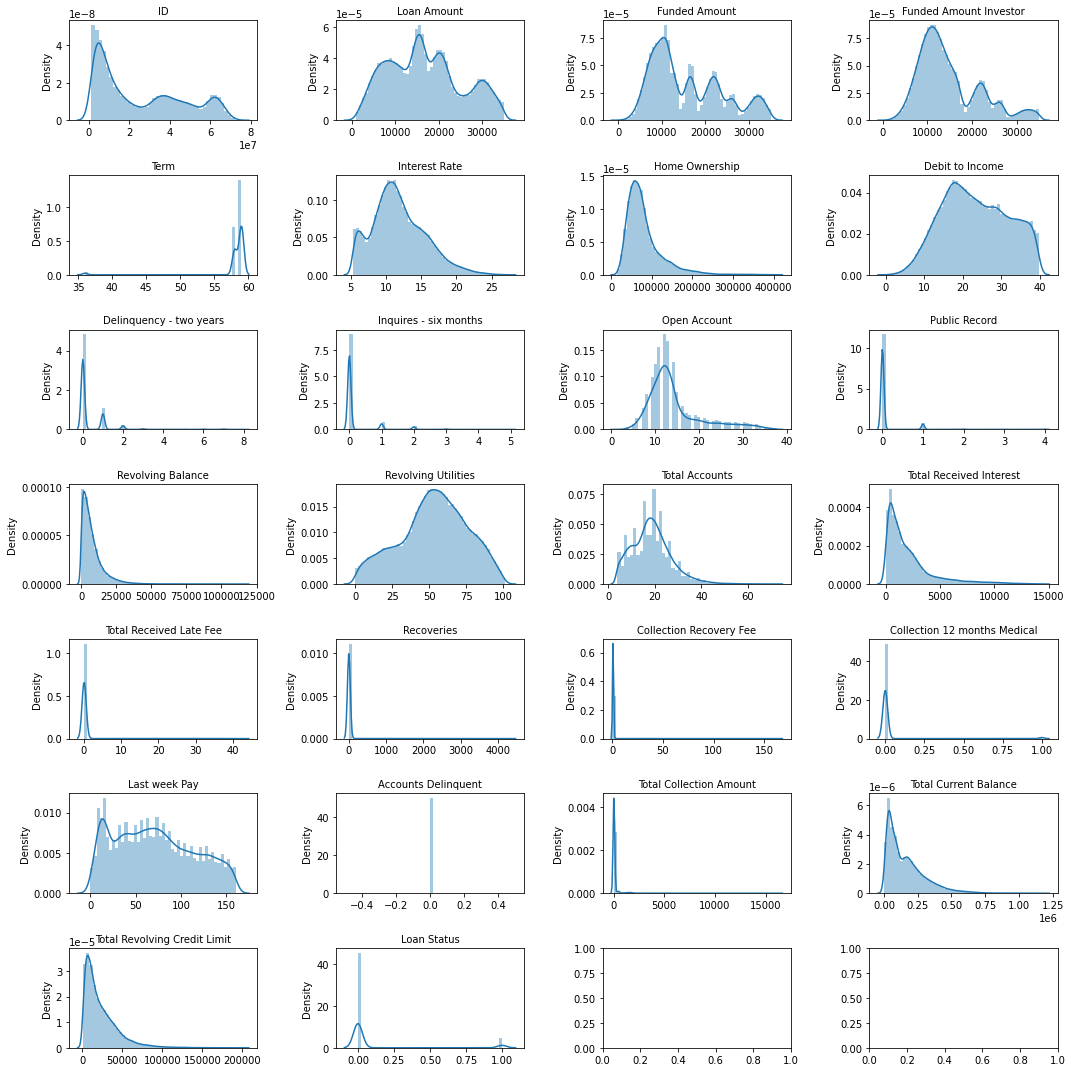

In [27]:

f, axes = plt.subplots(7, 4, figsize=(15,15))
idx1, idx2 = 0, 0
for column in numdata.columns:
  row = idx1//4
  col = idx1-row*4
  axes[row,col].set_title(column, fontsize = '10')
  sns.distplot(x=numdata[column], ax=axes[row][col])
  idx1+=1
  idx2 = (idx1//6) 
plt.tight_layout()

######From the above plot we can conclude that features like Total 

*   Total Received Late Fee, Total Collection Amount, Collection Recovery Fee, Recoveries, Accounts Delinquent, Collection 12 months Medical do not contribute to the variance/information required for making prediction. They are either constants, highly imbalanced or vary within a very small range. 

*   We also conclude that the target variable is also imbalanced. 



In [28]:
obj_cols = dtypesdf.loc[dtypesdf[0]==object]
objdata = data[list(obj_cols['index'])]

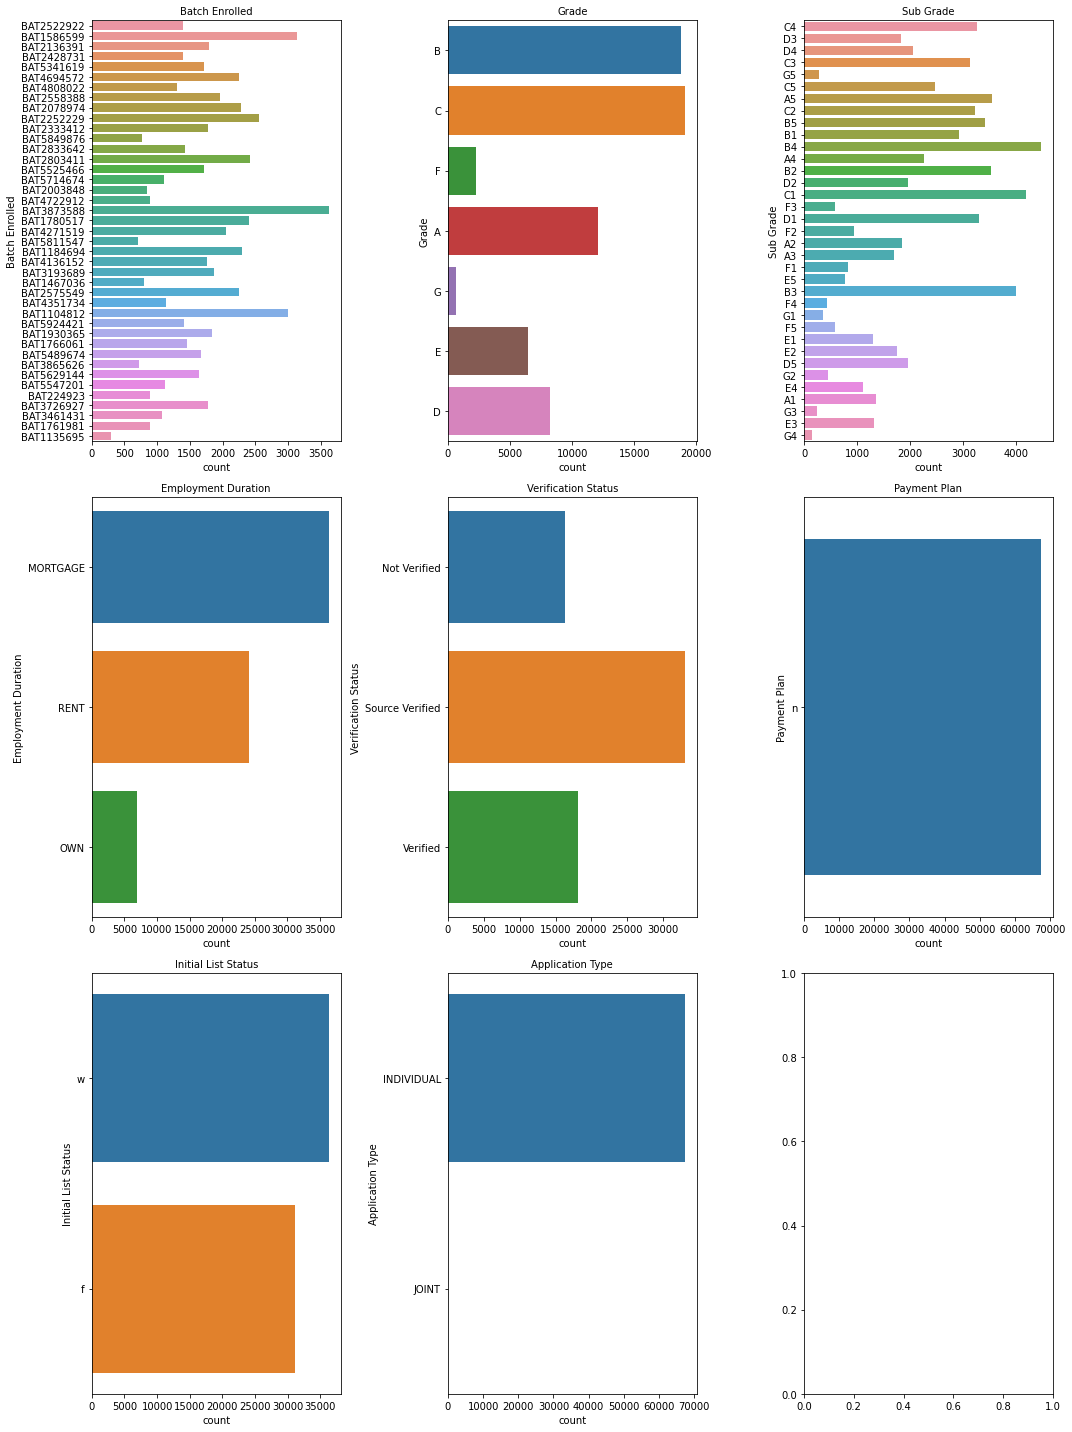

In [29]:
f, axes = plt.subplots(3, 3, figsize=(15,20))
idx1, idx2 = 0, 0
for column in objdata.columns:
  if column=="Loan Title":
    continue
  row = idx1//3
  col = idx1-row*3
  axes[row,col].set_title(column, fontsize = '10')
  sns.countplot(y=objdata[column], ax=axes[row][col])
  idx1+=1
plt.tight_layout()

#####From the plots we can conclude:

*   Loan titles is not quite understandable from the figure we need to inspect
*   Payment Plan, Application Type have constant values thus they do not contribute to any additional information that might be useful for prediction 



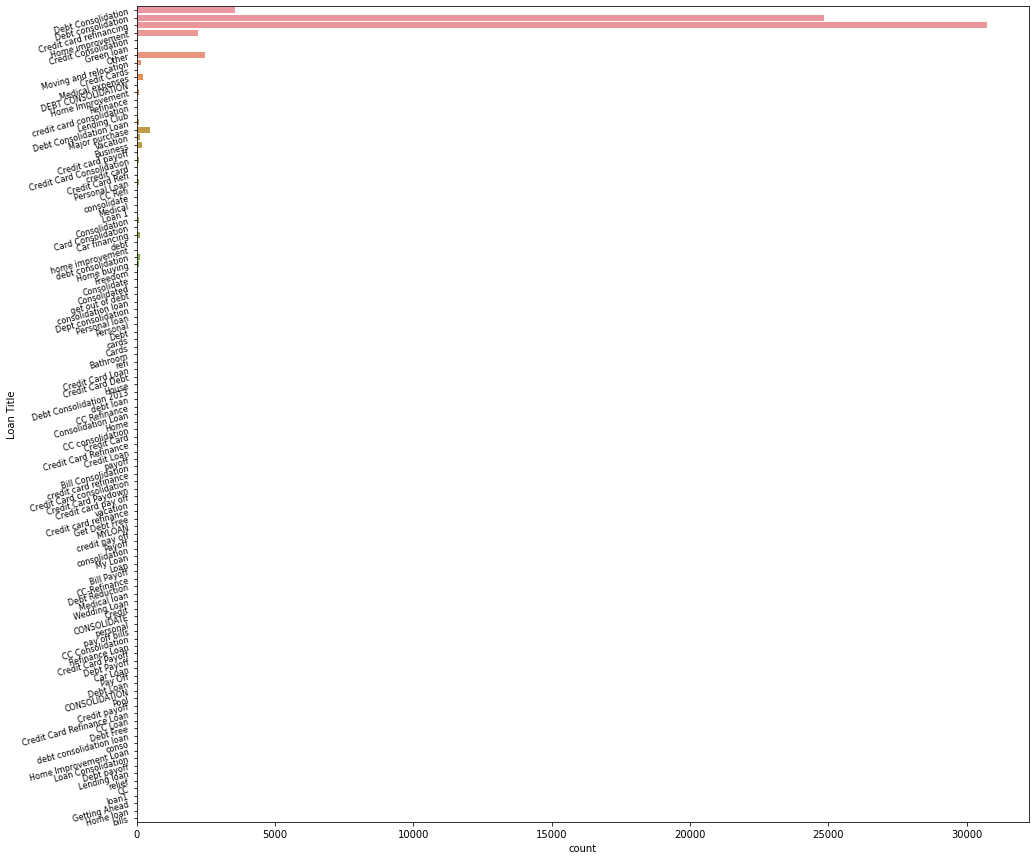

In [30]:
plt.figure(figsize=(16,15))
plt.yticks(rotation=15, fontsize=8)
sns.countplot(y=objdata["Loan Title"])

In [31]:
dfinsp1 = objdata.groupby("Loan Title").agg("count")["Grade"].reset_index()
dfinsp1

,Loan Title,Grade
0,Bathroom,14
1,Bill Consolidation,15
2,Bill Payoff,12
3,Business,183
4,CC,6
...,...,...
104,payoff,50
105,personal,26
106,refi,25
107,relief,9


#####Retaining Loan titles with atleast 25 available records

In [32]:
titlestokeep = dfinsp1.loc[dfinsp1["Grade"]>25]

In [33]:
titlestokeep

,Loan Title,Grade
3,Business,183
14,Car financing,135
17,Consolidate,55
19,Consolidation,97
20,Consolidation Loan,55
22,Credit Card,34
23,Credit Card Consolidation,68
24,Credit Card Debt,45
25,Credit Card Loan,30
27,Credit Card Payoff,35


####Let us check for available null values

In [34]:
data.isnull().mean()*100

ID                              0.0
Loan Amount                     0.0
Funded Amount                   0.0
Funded Amount Investor          0.0
Term                            0.0
Batch Enrolled                  0.0
Interest Rate                   0.0
Grade                           0.0
Sub Grade                       0.0
Employment Duration             0.0
Home Ownership                  0.0
Verification Status             0.0
Payment Plan                    0.0
Loan Title                      0.0
Debit to Income                 0.0
Delinquency - two years         0.0
Inquires - six months           0.0
Open Account                    0.0
Public Record                   0.0
Revolving Balance               0.0
Revolving Utilities             0.0
Total Accounts                  0.0
Initial List Status             0.0
Total Received Interest         0.0
Total Received Late Fee         0.0
Recoveries                      0.0
Collection Recovery Fee         0.0
Collection 12 months Medical

####Let us also look for correlations between the numerical variables

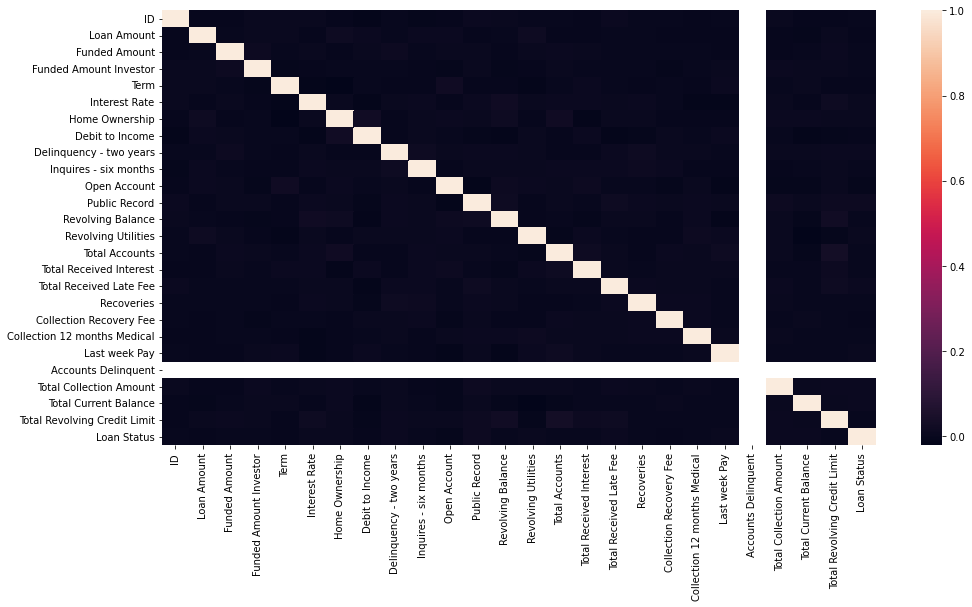

In [35]:
plt.figure(figsize=(16,8))
sns.heatmap(numdata.corr())

#####From the above plot we observe the following:

*   All variablese except Accounts Delinquent have insignificant correlation with each other
*   From a previous plot we had found that Accounts Delinquent had a constant value. Thus, our heatmap of correlations is aligned with that observation.



##Data Preprocessing

In [36]:
test_data = pd.read_csv("test.csv")

In [68]:
df = pd.concat([data, test_data],axis = 0).reset_index(drop = True)
df = pd.concat([test_data.assign(ind='test'), data.assign(ind='train')], axis = 0)

In [69]:
#Removing unnecessary variables as found during EDA

df = df.drop(["Total Received Late Fee", "Total Collection Amount", "Collection Recovery Fee", "Recoveries", "Accounts Delinquent", "Collection 12 months Medical", "Payment Plan", "Application Type"], axis=1)

In [70]:
# Remove space in the columns
df.columns = df.columns.str.replace('-','')
df.columns = df.columns.str.replace(' ','_')

#####Feature Engineering

In [73]:
df['Available_Accounts'] = df['Total_Accounts'] - df['Open_Account']
df = df.drop(['Total_Accounts', 'Open_Account'], axis=1)

In [72]:
numdata.columns = numdata.columns.str.replace('-','')
numdata.columns = numdata.columns.str.replace(' ','_')

##Outlier Treatment

In [41]:
numdatanew = numdata.drop(["Total_Received_Late_Fee", "Total_Collection_Amount", "Collection_Recovery_Fee", "Recoveries", "Accounts_Delinquent", "Collection_12_months_Medical"], axis=1)

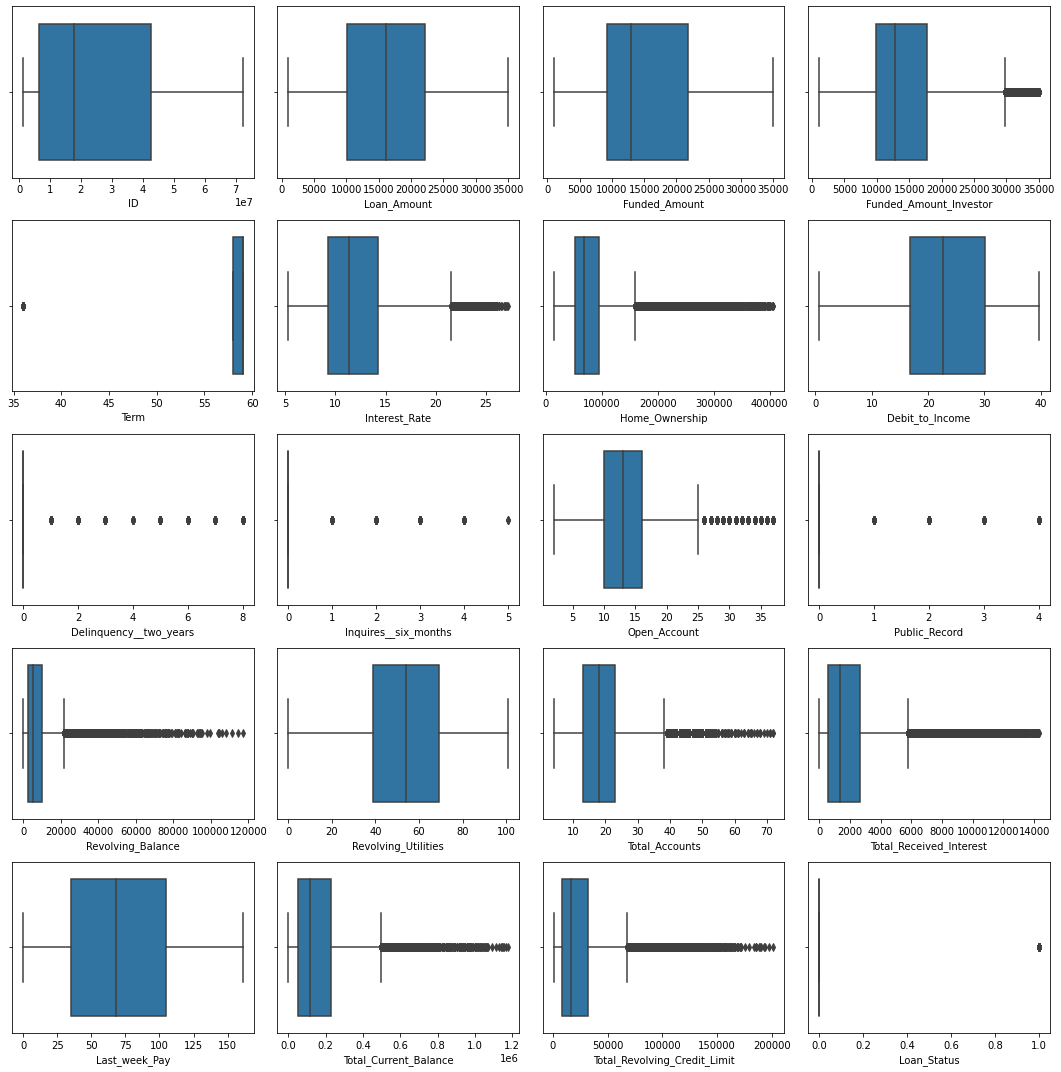

In [74]:
f, axes = plt.subplots(5, 4, figsize=(15,15))
idx1, idx2 = 0, 0
for column in numdatanew.columns:
  row = idx1//4
  col = idx1-row*4
  # axes[row,col].set_title(column, fontsize = '10')
  sns.boxplot(x=numdatanew[column], ax=axes[row][col])
  idx1+=1
  idx2 = (idx1//6) 
plt.tight_layout()

#####Some variables have some serious outlier issues. For instance Delinquencytwo_years, Public_Record, Inquiressix_months. Although certain other variables also show outliers however unusual transactions might as well mean cases of frauds. Thus we remove those outliers very seletively. 

In [43]:
#Outlier removal iteration 1

u1 = df["Delinquency__two_years"].mean()
stdev1 = df["Delinquency__two_years"].std()
u2 = df["Total_Received_Interest"].mean()
stdev2 = df["Total_Received_Interest"].std()
u3 = df["Inquires__six_months"].mean()
stdev3 = df["Inquires__six_months"].std()
df = df.loc[(df["Delinquency__two_years"]<u1+2*stdev1) & (df["Total_Received_Interest"]<u2+3*stdev2) & (df["Inquires__six_months"]<u3+2*stdev3)]

In [44]:
#Outlier removal iteration 2

u1 = df["Revolving_Balance"].mean()
stdev1 = df["Revolving_Balance"].std()
u2 = df["Total_Revolving_Credit_Limit"].mean()
stdev2 = df["Total_Revolving_Credit_Limit"].std()
u3 = df["Total_Accounts"].mean()
stdev3 = df["Total_Accounts"].std()
df = df.loc[(df["Revolving_Balance"]<u1+3*stdev1) & (df["Total_Revolving_Credit_Limit"]<u2+3*stdev2) & (df["Total_Accounts"]<u3+3*stdev3)]

####Checking the presence of outliers once again

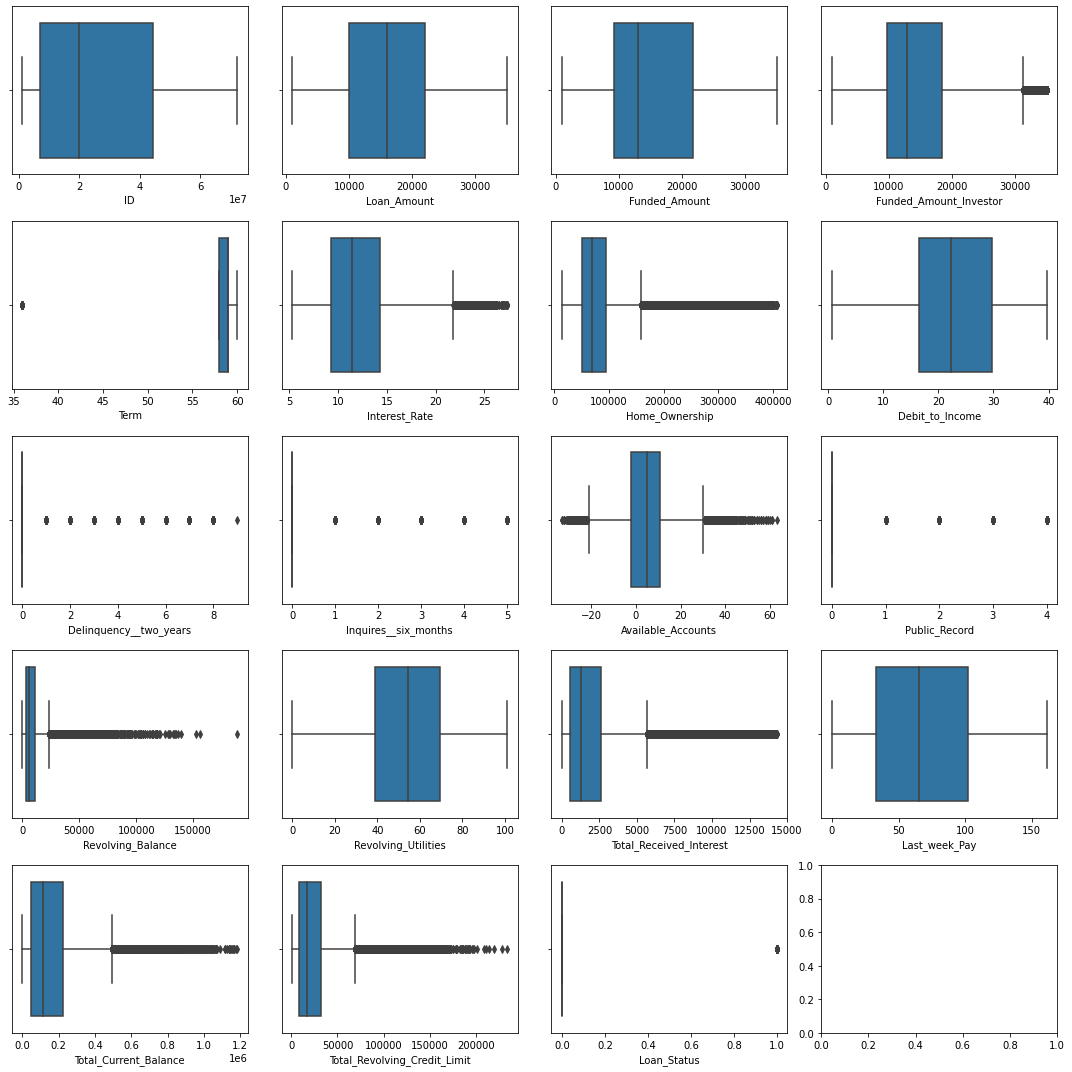

In [76]:
f, axes = plt.subplots(5, 4, figsize=(15,15))
idx1, idx2 = 0, 0
for column in numdatanew.columns:
  row = idx1//4
  col = idx1-row*4
  if column=='Open_Account':
    column='Available_Accounts'
  if column=='Total_Accounts':
    continue  
  sns.boxplot(x=df[column], ax=axes[row][col])
  idx1+=1
  idx2 = (idx1//6) 
plt.tight_layout()

#####In the above plots we can see that number of outliers for certain categories have dropped. Howevee, Available_Accounts has a negative tail, which maybe due to incorrect imputation.

In [77]:
df['Available_Accounts'] = abs(df['Available_Accounts'])

##Dealing with inconsistent labels

In [78]:
df['Verification_Status'].unique()

array(['Source Verified', 'Verified', 'Not Verified'], dtype=object)

In [79]:
df['Loan_Title'].unique()

array(['Home improvement', 'Credit card refinancing',
       'Debt consolidation', 'Debt Consolidation', 'CC Loan',
       'credit card refinance', 'Credit Card Consolidation', 'MYLOAN',
       'Other', 'CC Consolidation', 'Moving and relocation', 'Car Loan',
       'Bill Payoff', 'Car financing', 'Personal', 'Credit Consolidation',
       'credit card consolidation', 'Home Improvement', 'Personal Loan',
       'Medical expenses', 'personal', 'Consolidation', 'CONSOLIDATE',
       'Refinance', 'Business', 'DEBT CONSOLIDATION', 'Major purchase',
       'Home Improvement Loan', 'refi', 'Credit Card Debt',
       'Consolidation Loan', 'consolidation loan', 'Vacation',
       'debt consolidation', 'consolidate', 'Consolidate',
       'Credit card payoff', 'Credit Card Refinance', 'home improvement',
       'payoff', 'Debt Consolidation Loan', 'Credit Cards',
       'CC-Refinance', 'Debt payoff', 'debt consolidation loan',
       'Credit card pay off', 'Green loan', 'loan1', 'credit card',


Columns Verification Status and Loan Title have inconsistent labels. It can be corrected using dictionaries for each column.

In [80]:
title = pd.DataFrame(df['Loan_Title'].value_counts())

In [81]:
## Correct the labels in Loan Title
title_dict = {'Debt Consolidation 2013': 'debt_consolidation','Debt Reduction':'debt_consolidation','Debt':'debt_consolidation','conso':'debt_consolidation',
'debt loan': 'debt_consolidation','get out of debt':'debt_consolidation','Consolidated':'debt_consolidation','Debt Payoff':'debt_consolidation',
'Loan Consolidation': 'debt_consolidation','relief':'debt_consolidation','Lending Club':'debt_consolidation','Debt Loan':'debt_consolidation',
'CONSOLIDATION': 'debt_consolidation','Get Debt Free':'debt_consolidation','Freedom':'debt_consolidation','consolidation':'debt_consolidation','Lending loan':'debt_consolidation',
'Debt Free': 'debt_consolidation','Debt Consolidation Loan':'debt_consolidation','Debt payoff':'debt_consolidation','debt consolidation loan':'debt_consolidation',
'Consolidation': 'debt_consolidation','Debt Consolidation':'debt_consolidation','Debt consolidation':'debt_consolidation','CONSOLIDATE':'debt_consolidation',
'DEBT CONSOLIDATION': 'debt_consolidation','Consolidation Loan':'debt_consolidation','consolidation loan':'debt_consolidation','debt consolidation':'debt_consolidation',
'consolidate': 'debt_consolidation','Consolidate':'debt_consolidation','debt':'debt_consolidation','Credit Card':'credit_card','Credit Card consolidation':'credit_card',
'Dept consolidation':'debt_consolidation','CC Refi': 'credit_card','pay off bills':'credit_card','CC-Refinance':'credit_card','Refinance Loan':'credit_card',
'bills': 'credit_card','Credit':'credit_card','Credit Card Paydown':'credit_card','Credit Card Refinance Loan':'credit_card',
'credit pay off': 'credit_card','Credit card refinancing':'credit_card','CC Loan':'credit_card','credit card refinance':'credit_card',
'Credit Card Loan': 'credit_card','Credit Card Consolidation':'credit_card','Card Consolidation':'credit_card','CC consolidation':'credit_card',
'Bill Payoff': 'credit_card','Credit Consolidation':'credit_card','credit card consolidation':'credit_card','Refinance':'credit_card',
'refi':'credit_card','Credit Card Debt':'credit_card','Credit card payoff':'credit_card','Credit Card Refinance':'credit_card','CC Consolidation':'credit_card',
'payoff':'credit_card','Credit Cards':'credit_card','CC Refinance':'credit_card','Credit card pay off':'credit_card','cards':'credit_card',
'credit card':'credit_card','Credit Card Refi':'credit_card','Cards':'credit_card','Pay Off':'credit_card',
'Credit Loan':'credit_card','Credit Card Payoff':'credit_card','CC':'credit_card','Payoff':'credit_card',
'Credit card refinance':'credit_card','Bill Consolidation':'credit_card','Credit payoff':'credit_card','Home improvement':'BuyingHouse&HomeImprovement',
'Home Improvement':'BuyingHouse&HomeImprovement','Home Improvement Loan':'BuyingHouse&HomeImprovement','home improvement':'BuyingHouse&HomeImprovement','Pool':'BuyingHouse&HomeImprovement',
'Home buying':'BuyingHouse&HomeImprovement','House':'BuyingHouse&HomeImprovement','Home':'BuyingHouse&HomeImprovement','Bathroom':'BuyingHouse&HomeImprovement',
'Home loan':'BuyingHouse&HomeImprovement','Getting Ahead': 'BuyingHouse&HomeImprovement','Moving and relocation':'moving','other':'Other','vacation':'vacation',
'Vacation':'vacation','Wedding Loan':'wedding','MYLOAN':'personal','Personal':'personal',
'Personal Loan': 'personal','loan1':'personal','Loan 1':'personal','My Loan':'personal',
'Loan': 'personal','Personal loan':'personal','Major purchase':'major_purchase','Medical expenses':'medical',
'Medical loan': 'medical','Medical':'medical','Car Loan':'car','Car financing':'car',
'car':'car','Business': 'business','Green loan':'renewable_energy'}
df['Loan_Title'].replace(title_dict, inplace = True)

In [82]:
df['Loan_Title'].unique()

array(['BuyingHouse&HomeImprovement', 'credit_card', 'debt_consolidation',
       'personal', 'Other', 'moving', 'car', 'medical', 'business',
       'major_purchase', 'vacation', 'renewable_energy', 'wedding'],
      dtype=object)

##Splitting the dataset into train and test sets

In [83]:
test, train = df[df['ind'].eq('test')], df[df['ind'].eq('train')]

In [84]:
# Drop 'ind' column from test and train datasets
train.drop(['ind'], axis=1, inplace=True)
test.drop(['ind','Loan_Status'], axis=1, inplace=True)

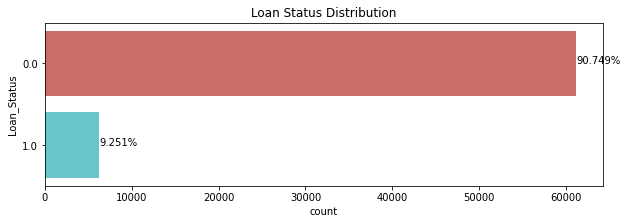

In [85]:
## Overall distribution of Loan Status

#Countplot of loan status
plt.figure(figsize=(10,3))
ax=sns.countplot(y='Loan_Status',data=df, palette='hls',order = train['Loan_Status'].value_counts().index)
plt.title('Loan Status Distribution')
total = len(train['Loan_Status'])
for p in ax.patches:
        percentage = '{:.3f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

Out of 67463 loan applicants, 90.75% applicants are non-defaulters and 9.25% have defaulted. 

This also means that the train dataset is imbalanced. To resolve this, stratified K-fold cross validation with shuffle setting as True will be used to ensure equal distribution of the Loan Status labels during building the model.

##Encoding Categorical Variables

As we will be using tree-based algorithms for building the model, we shall choose label encoding for encoding categorical variables. 

In [86]:
features = ['Grade','Verification_Status','Initial_List_Status','Loan_Title', 'Batch_Enrolled', 'Employment_Duration', 'Sub_Grade']

le = LabelEncoder()

# Fit the encoder and tranform each column
for col in features:
    train.loc[:, col]= le.fit_transform(train[col])

train = pd.DataFrame(train, columns = train.columns)

##Splitting the training set 

####Splitting in Feature matrix(X) and target labels(y)

In [106]:
X = train.drop(["Loan_Status"], axis=1)
y = train["Loan_Status"]

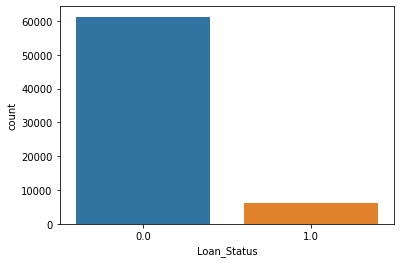

In [90]:
sns.countplot(y) #Keeping this plot as a reference for later

Since the dataset is imbalanced we must use stratified split

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=train["Loan_Status"])

#####Referring to the previous frequency plot we find y_train has the same distribution of positive samples and negative samples

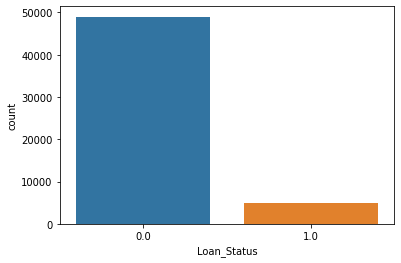

In [92]:
sns.countplot(y_train) 

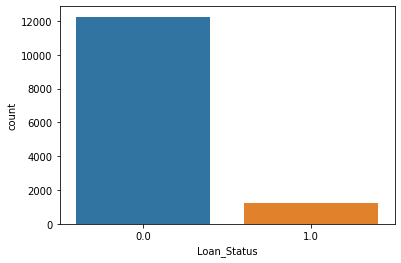

In [93]:
sns.countplot(y_test) 

##Treating Class imbalance with SMOTE

In [176]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

#####From the below frequency plot it can be observed that the class imbalance is no longer there.

*SMOTE is oversampling the positive cases which are in deficit in the dataset. Oversampling in this way should in general increase the number of false positives.* 

Although this can be potentially dangerous for certain businesses, however in our case that is not so. This is because in the case of loan defaults false negatives should be intuitively more dangerous than false postives, i.e, defaulters getting predicted as clean(false negative) are much more harmful than a non-defaulter being predicted to default(false positive).  

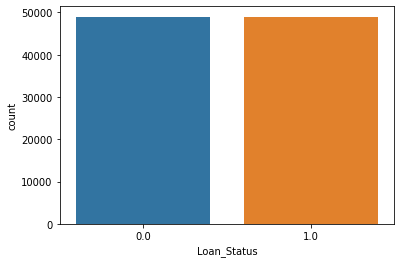

In [108]:
sns.countplot(y_resampled)

First we train the machine learning model on the preprocessed dataset. Then we'll use the generated dataset to try improve our prediction. This is because the generated data may add false information to our model.

##Scaling the Data

In [64]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46220 entries, 36387 to 36540
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            46220 non-null  int64  
 1   Loan_Amount                   46220 non-null  int64  
 2   Funded_Amount                 46220 non-null  int64  
 3   Funded_Amount_Investor        46220 non-null  float64
 4   Term                          46220 non-null  int64  
 5   Batch_Enrolled                46220 non-null  int64  
 6   Interest_Rate                 46220 non-null  float64
 7   Grade                         46220 non-null  int64  
 8   Sub_Grade                     46220 non-null  int64  
 9   Employment_Duration           46220 non-null  int64  
 10  Home_Ownership                46220 non-null  float64
 11  Verification_Status           46220 non-null  int64  
 12  Loan_Title                    46220 non-null  int64  
 1

In [98]:
# List for columns to scale
cols_to_scale = ['Term','Interest_Rate','Employment_Duration','Debit_to_Income','Inquires__six_months','Public_Record',
'Available_Accounts','Loan_Amount','Funded_Amount_Investor']

# Create scaler
scaler = StandardScaler()

# Create a copy of the datasets
X_train_scaled = X_train.copy()
test_scaled = test.copy()

# Scale selected data
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)

In [141]:
X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [101]:
X_train_scaled = X_train_scaled.drop("ID", axis=1)

In [142]:
X_test_scaled = X_test_scaled.drop(["ID"], axis=1)

In [102]:
X_train_scaled

,Loan_Amount,Funded_Amount,Funded_Amount_Investor,Term,Batch_Enrolled,Interest_Rate,Grade,Sub_Grade,Employment_Duration,Home_Ownership,...,Inquires__six_months,Public_Record,Revolving_Balance,Revolving_Utilities,Initial_List_Status,Total_Received_Interest,Last_week_Pay,Total_Current_Balance,Total_Revolving_Credit_Limit,Available_Accounts
30729,0.380433,13277,-0.923190,0.249183,20,-0.271676,0,5,-0.877167,94624.72442,...,-0.308362,-0.232833,8145,27.446031,1,830.012175,134,164193,20871,0.599213
20124,0.538301,11512,-0.378859,0.249183,16,-1.224365,3,9,-0.877167,88626.35122,...,1.817637,-0.232833,22940,18.454492,0,2607.692362,85,14454,53801,0.599213
24417,0.051071,7303,-1.804194,-0.048995,7,-1.132817,1,8,0.199198,85355.98163,...,1.817637,2.656563,37043,62.072446,0,1170.081118,36,404290,38265,-0.845754
10142,0.025975,10782,-0.659702,0.249183,4,-0.552044,0,13,-0.877167,33707.22095,...,-0.308362,-0.232833,3941,88.025882,1,67.653421,65,179218,26360,0.165723
54677,0.637492,31052,0.890126,0.249183,12,1.328889,2,18,0.199198,59947.18755,...,-0.308362,-0.232833,7399,21.221142,0,5097.182332,122,52602,2815,-0.701257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,-0.388476,18362,-0.412236,0.249183,0,-0.613893,5,5,-0.877167,46737.59678,...,-0.308362,-0.232833,11249,53.433118,1,3418.653162,123,204638,7205,-1.279244
65687,-0.544791,25545,-0.918801,0.249183,13,-0.529803,1,17,1.275564,212038.29520,...,-0.308362,-0.232833,3320,26.554974,1,1986.762080,40,409163,3918,1.032703
17448,-0.044295,22615,0.391938,-0.048995,17,-0.532691,4,11,-0.877167,84092.43229,...,-0.308362,-0.232833,6158,15.985932,1,8456.552095,79,436331,2285,-1.134748
53329,1.066881,26906,0.268892,0.249183,11,0.039588,2,10,-0.877167,55671.30937,...,-0.308362,-0.232833,14711,42.799793,0,2610.418422,145,89009,56540,0.021226


Scaling the resampled data as well

In [109]:
# List for columns to scale
cols_to_scale = ['Term','Interest_Rate','Employment_Duration','Debit_to_Income','Inquires__six_months','Public_Record',
'Available_Accounts','Loan_Amount','Funded_Amount_Investor']

# Create scaler
scaler2 = StandardScaler()

# Create a copy of the datasets
X_resampled_scaled = X_resampled.copy()

# Scale selected data
X_resampled_scaled[cols_to_scale] = scaler2.fit_transform(X_resampled[cols_to_scale])
X_resampled_scaled = pd.DataFrame(X_resampled_scaled, columns = X_resampled.columns)

In [110]:
X_resampled_scaled = X_resampled_scaled.drop(["ID"], axis=1)

In [111]:
X_resampled_scaled

,Loan_Amount,Funded_Amount,Funded_Amount_Investor,Term,Batch_Enrolled,Interest_Rate,Grade,Sub_Grade,Employment_Duration,Home_Ownership,...,Inquires__six_months,Public_Record,Revolving_Balance,Revolving_Utilities,Initial_List_Status,Total_Received_Interest,Last_week_Pay,Total_Current_Balance,Total_Revolving_Credit_Limit,Available_Accounts
0,0.427446,13277,-0.998348,0.300005,20,-0.294049,0,5,-0.824988,94624.724420,...,-0.263434,-0.186424,8145,27.446031,1,830.012175,134,164193,20871,0.671833
1,0.598299,11512,-0.411146,0.300005,16,-1.320193,3,9,-0.824988,88626.351220,...,2.300085,-0.186424,22940,18.454492,0,2607.692362,85,14454,53801,0.671833
2,0.070996,7303,-1.948740,-0.009596,7,-1.221586,1,8,0.348906,85355.981630,...,2.300085,3.221752,37043,62.072446,0,1170.081118,36,404290,38265,-0.888152
3,0.043835,10782,-0.714109,0.300005,4,-0.596034,0,13,-0.824988,33707.220950,...,-0.263434,-0.186424,3941,88.025882,1,67.653421,65,179218,26360,0.203838
4,0.705647,31052,0.957784,0.300005,12,1.429924,2,18,0.348906,59947.187550,...,-0.263434,-0.186424,7399,21.221142,0,5097.182332,122,52602,2815,-0.732153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97949,0.000120,8738,1.263951,-0.009596,34,0.416804,0,4,-0.824988,58609.632985,...,-0.263434,-0.186424,8206,56.372383,1,2409.229796,88,127892,11597,0.359836
97950,0.239391,18399,-0.408061,-0.009596,24,-0.092557,2,19,0.348906,57971.118656,...,-0.263434,-0.186424,2885,67.469462,0,1670.825887,81,47278,6310,0.203838
97951,1.072315,17776,-0.295594,0.300005,17,-0.711327,2,11,-0.824988,55763.503660,...,-0.263434,-0.186424,5980,54.678083,0,627.052689,42,185153,4712,-0.732153
97952,-0.762186,23198,-0.469296,0.300005,13,0.255059,3,11,0.348906,94618.535420,...,-0.263434,-0.186424,17605,12.301151,0,1792.293464,43,56074,19983,0.827832


##Feature Selection

In [114]:
# Defin feature selection 
selector = SelectKBest(mutual_info_classif, k = 16)

# Apply transformation to the training set
X_new = selector.fit_transform(X_train_scaled, y_train)  

# Get names of the selected features
mask = selector.get_support()     

# Scores for selected features
print(selector.scores_)     

# Get a list of selected features
new_features = X_train_scaled.columns[mask]
print(new_features)   

X_tr = X_train_scaled[new_features]
test = test_scaled[new_features]

[0.00197845 0.00065069 0.         0.         0.00108242 0.00081738
 0.00306134 0.         0.00463012 0.         0.00443009 0.00585094
 0.00049324 0.         0.00326649 0.00347029 0.00179991 0.00234607
 0.00385194 0.00100605 0.         0.         0.00042285 0.00174406]
Index(['Loan_Amount', 'Funded_Amount', 'Batch_Enrolled', 'Interest_Rate',
       'Grade', 'Employment_Duration', 'Verification_Status', 'Loan_Title',
       'Debit_to_Income', 'Inquires__six_months', 'Public_Record',
       'Revolving_Balance', 'Revolving_Utilities', 'Initial_List_Status',
       'Total_Received_Interest', 'Available_Accounts'],
      dtype='object')


In [145]:
X_tst = X_test_scaled[new_features]

In [158]:
# X_resampled = X_resampled[new_features]

In [123]:
X_tr = X_tr.reset_index(drop=True)

In [126]:
y_train = y_train.reset_index(drop=True)

In [146]:
X_tst = X_tst.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [177]:
X_resampled = X_resampled.reset_index(drop=True)
y_resampled = y_resampled.reset_index(drop=True)

##Building Machine Learning Models

###Training on data with original distribution

In [150]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import log_loss, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [128]:
# Implement cross validation
def stkfold_cv(X, y, algorithm, params,n_jobs=-1):
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
 
 
    for train_index , test_index in skf.split(X,y):
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]

        model = algorithm(**params) 
        model.fit(X_train,y_train)
        pred = model.predict_proba(X_test)[:,1]
        pred_clipped = np.clip(pred,0.05,0.95)

        score = log_loss(y_test, pred)
        print(f'Log-loss: {score}')
        
    return model

####Model 1

In [129]:
## Initial Logit model
logit_params = {}
logit_model = stkfold_cv(X_tr,y_train,LogisticRegression,logit_params)

Log-loss: 0.31621730134018255
Log-loss: 0.3152197225897798
Log-loss: 0.3175264980266242
Log-loss: 0.3159582542469688
Log-loss: 0.31339358580536497


Hyperparameter Tuning to improve the model

In [131]:
# Define a grid of parameters
param_grid = {'penalty': ['l1','l2'],
'C': [0.001,0.01,0.1,1,10,100],}

# Initialize grid search
classifier = LogisticRegression(n_jobs=-1,random_state=42)

model = RandomizedSearchCV(estimator=classifier,
param_distributions=param_grid,
scoring='neg_log_loss',
verbose=10,
n_jobs=1,
cv=StratifiedKFold(5,shuffle=True))

# Fit the model and extract best score
model.fit(X_tr, y_train)
print(f'Best score: {model.best_score_}')
print('Best parameters set:')
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f'\t{param_name}: {best_parameters[param_name]}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=0.001, penalty=l2........................................
[CV 1/5; 1/10] END ........C=0.001, penalty=l2;, score=-0.317 total time=   2.1s
[CV 2/5; 1/10] START C=0.001, penalty=l2........................................
[CV 2/5; 1/10] END ........C=0.001, penalty=l2;, score=-0.317 total time=   1.6s
[CV 3/5; 1/10] START C=0.001, penalty=l2........................................
[CV 3/5; 1/10] END ........C=0.001, penalty=l2;, score=-0.315 total time=   1.2s
[CV 4/5; 1/10] START C=0.001, penalty=l2........................................
[CV 4/5; 1/10] END ........C=0.001, penalty=l2;, score=-0.314 total time=   1.3s
[CV 5/5; 1/10] START C=0.001, penalty=l2........................................
[CV 5/5; 1/10] END ........C=0.001, penalty=l2;, score=-0.315 total time=   1.2s
[CV 1/5; 2/10] START C=100, penalty=l2..........................................
[CV 1/5; 2/10] END ..........C=100, penalty=l2;,

Training the Logistic regression model with tuned hyperparameters

In [132]:
## Logit model with tuned hyperparameters
logit_params = {'penalty':'l2','C': 0.1}
logit_model = stkfold_cv(X_tr,y_train,LogisticRegression,logit_params)

Log-loss: 0.3162037490681814
Log-loss: 0.31521906529887356
Log-loss: 0.31752489013090807
Log-loss: 0.3159580339820675
Log-loss: 0.3133935120069188


####Model 2

In [135]:
## Initial Random Forest model
rf_params = {}
rf_model = stkfold_cv(X_tr, y_train,RandomForestClassifier,rf_params)

Log-loss: 0.32404054799560705
Log-loss: 0.3209209227494773
Log-loss: 0.3190116241736597
Log-loss: 0.3195336882012768
Log-loss: 0.3210565519468517


In [136]:
## Hyperparameter Tuning for Random Forest Classifier
from sklearn import model_selection

# Define a grid of parameters
param_grid = {'n_estimators': [100, 200, 250, 300, 400, 500],
'max_depth': [1, 2, 5, 7, 11, 15],
'criterion': ['gini', 'entropy'],
'min_samples_split': [1, 2, 5, 10, 15, 100],
'min_samples_leaf': [1, 2, 5, 10],
'max_features': ['log2', 'sqrt','None']}

# Initialize randomized search
classifier = RandomForestClassifier(n_jobs=-1,random_state=42)

model = model_selection.RandomizedSearchCV(estimator=classifier,
param_distributions=param_grid,
scoring='neg_log_loss',
verbose=10,
n_jobs=1,
cv=StratifiedKFold(5,shuffle=True))

# Fit the model and extract best score
model.fit(X_tr, y_train)
print(f'Best score: {model.best_score_}')
print('Best parameters set:')
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f'\t{param_name}: {best_parameters[param_name]}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 1/5; 1/10] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=-0.308 total time=  40.8s
[CV 2/5; 1/10] START criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 2/5; 1/10] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=-0.309 total time=  38.9s
[CV 3/5; 1/10] START criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 3/5; 1/10] END criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=-0.308 total time=  38.9s
[CV 4/5; 1/10] START criterion=entropy, max_depth=7, max_

Training Random Forest model with tuned hyperparameters

In [137]:
rf_params = {'n_estimators':200,
'max_depth': 5,'criterion': 'entropy',
'min_samples_split': 5,
'min_samples_leaf': 1,
'max_features':'log2'} 
rf_model = stkfold_cv(X_tr, y_train,RandomForestClassifier,rf_params)

Log-loss: 0.3083797531557429
Log-loss: 0.30869770982881767
Log-loss: 0.308294174702992
Log-loss: 0.3079341872207546
Log-loss: 0.30792462485598787


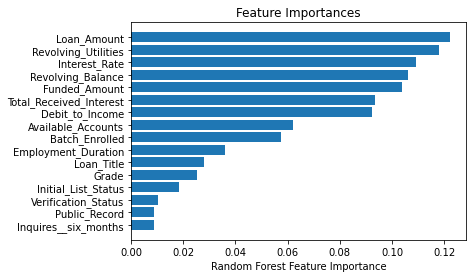

In [138]:
col_names = X_tr.columns
importances = rf_model.feature_importances_
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

###Training on resampled data

####Model 1

In [178]:
## Initial Logit model
logit_params = {}
logit_model = stkfold_cv(X_resampled,y_resampled,LogisticRegression,logit_params)

Log-loss: 0.69264668603918
Log-loss: 0.6929420306401601
Log-loss: 0.6926618613725853
Log-loss: 0.6927004961752639
Log-loss: 0.6930628103951708


Hyperparameter Tuning to improve model

In [179]:
# Define a grid of parameters
param_grid = {'penalty': ['l1','l2'],
'C': [0.001,0.01,0.1,1,10,100],}

# Initialize grid search
classifier = LogisticRegression(n_jobs=-1,random_state=42)

model = RandomizedSearchCV(estimator=classifier,
param_distributions=param_grid,
scoring='neg_log_loss',
verbose=10,
n_jobs=1,
cv=StratifiedKFold(5,shuffle=True))

# Fit the model and extract best score
model.fit(X_resampled, y_resampled)
print(f'Best score: {model.best_score_}')
print('Best parameters set:')
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f'\t{param_name}: {best_parameters[param_name]}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=0.01, penalty=l1.........................................
[CV 1/5; 1/10] END ............C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 2/5; 1/10] START C=0.01, penalty=l1.........................................
[CV 2/5; 1/10] END ............C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 3/5; 1/10] START C=0.01, penalty=l1.........................................
[CV 3/5; 1/10] END ............C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 4/5; 1/10] START C=0.01, penalty=l1.........................................
[CV 4/5; 1/10] END ............C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 5/5; 1/10] START C=0.01, penalty=l1.........................................
[CV 5/5; 1/10] END ............C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 1/5; 2/10] START C=0.1, penalty=l1..........................................
[CV 1/5; 2/10] END .............C=0.1, penalty=l

Training the Logistic regression model with trained hyperparameters

In [180]:
## Logit model with tuned hyperparameters
logit_params = {'penalty':'l2','C': 0.001}
logit_model = stkfold_cv(X_resampled,y_resampled,LogisticRegression,logit_params)

Log-loss: 0.6926215992632055
Log-loss: 0.6929420306401611
Log-loss: 0.6926618613726158
Log-loss: 0.6927004961751255
Log-loss: 0.6930628103951685


####Model 2

In [181]:
## Random Forest model
rf_params = {}
rf_model = stkfold_cv(X_resampled, y_resampled,RandomForestClassifier,rf_params)

Log-loss: 0.37670342334369805
Log-loss: 0.37239085236664643
Log-loss: 0.37090151774059166
Log-loss: 0.374056124810487
Log-loss: 0.3728831641419003


Training the Random forest model with tuned hyperparameters

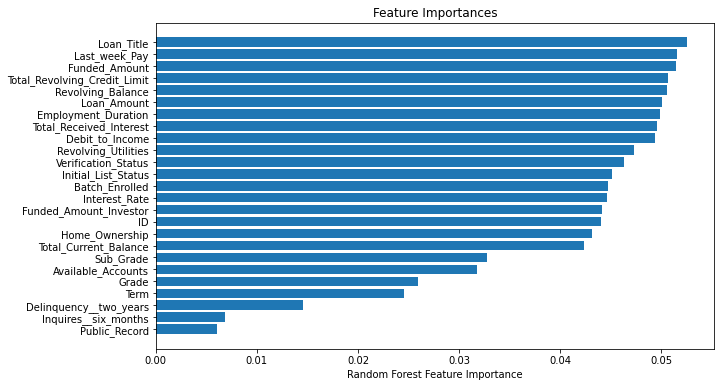

In [192]:
col_names = X_resampled.columns
importances = rf_model.feature_importances_
idxs = np.argsort(importances)
plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

##Performance on test data

###Models trained on data with original distribution

####Model 1 Analysis

In [148]:
logit_preds = logit_model.predict(X_tst)

In [152]:
print(classification_report(logit_preds, y_test))

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95     13493
         1.0       0.00      0.00      0.00         0

    accuracy                           0.91     13493
   macro avg       0.50      0.45      0.48     13493
weighted avg       1.00      0.91      0.95     13493



####Model 2 Analysis

In [153]:
rf_preds = rf_model.predict(X_tst)

In [155]:
print(classification_report(rf_preds, y_test))

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95     13493
         1.0       0.00      0.00      0.00         0

    accuracy                           0.91     13493
   macro avg       0.50      0.45      0.48     13493
weighted avg       1.00      0.91      0.95     13493



###Models trained with resampled data

####Model 1 analysis

In [172]:
logit_preds = logit_model.predict(X_tst)

In [173]:
print(classification_report(logit_preds, y_test))

              precision    recall  f1-score   support

         0.0       0.47      0.91      0.62      6409
         1.0       0.52      0.09      0.16      7084

    accuracy                           0.48     13493
   macro avg       0.50      0.50      0.39     13493
weighted avg       0.50      0.48      0.38     13493



####Model 2 analysis

In [183]:
rf_preds = rf_model.predict(X_test)

In [184]:
print(classification_report(rf_preds, y_test))

              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90     11965
         1.0       0.11      0.09      0.10      1528

    accuracy                           0.81     13493
   macro avg       0.50      0.50      0.50     13493
weighted avg       0.80      0.81      0.81     13493



##Conclusion

Comparing all the 4 models we find that the models fitted on data with original distribution have no capacity of predicting the true positives, owing to the lack of samples of that class during training.

However, the models trained on data after SMOTE resampling are able to predict true positives observed from the increased precision, recall and f1-score, at the cost of accuracy. The second model generalizes much better and thus, we select the Random Forest regressor trained on resampled data as our solution.



---

